#### =============================================================================
### Copyright 2025. Somjit Roy and Pritam Dey. 
### This program implements the TAVIE algorithm as developed in:
### Roy, S., Dey, P., Pati, D., and Mallick, B.K.
### 'A Generalized Tangent Approximation Framework for Strongly Super-Gaussian Likelihoods',
### arXiv:2504.05431 <https://arxiv.org/abs/2504.05431>.
### We compare TAVIE for the Laplace model against competing methods.
###
### Authors:
###   Somjit Roy (<sroy_123@tamu.edu>) and Pritam Dey (<pritam.dey@tamu.edu>)
#### =============================================================================

This `ipynb` compares the **TAVIE** algorithm to different state-of-the-art variational algorithms applied under Laplace SSG likleihood.
* **Laplace SSG**: `TAVIE` versus `ADVI mean-field`, `ADVI full-rank`, `DADVI` and `NUTS`.

In [1]:
# Required for DADVI experiments, running TAVIE and other BBVI algorithms
import pymc as pm
import pytensor
import pytensor.tensor as pt
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
import jax
import jax.numpy as jnp
setattr(jnp, "product", jnp.prod)
jax.config.update("jax_enable_x64", True)
from CompetingMethods import *
from dadvi.pymc.jax_api import fit_pymc_dadvi_with_jax
from TAVIE import *
import rich
from sklearn.preprocessing import scale
from IPython.display import display, Latex
from time import perf_counter
from tqdm import tqdm, trange
from scipy.stats import t
import arviz as az
import re

### True synthetic Laplace data generation, n=10000, p=5 (+ intercept)

In [2]:
# Generate synthetic data for Laplace regression
n = 10000
p = 5
tau2_true = 8
beta_true = np.random.normal(loc=0.0, scale=1.0, size=p+1)

X = np.random.normal(size=(n, p))
X_bbvi = np.column_stack((np.ones(n), X))
error = np.random.laplace(size=n, scale=1/np.sqrt(tau2_true))
y = beta_true[0] + X @ beta_true[1:len(beta_true)] + error

### Code for the Laplace PyMC model and fitting Laplace NUTS model || Also fitting the TAVIE Laplace model || Fitting ADVI algorithms

In [3]:
def laplace_pymc_model(X, y, a0=0.05, b0=0.05):
    """
    Build and return a PyMC Laplace regression model:
        y ~ Laplace(mu = X @ beta, b)

    Parameters
    ----------
    X : array-like, shape (n,) or (n, p)
    y : array-like, shape (n,)

    Returns
    -------
    model : pm.Model
    """
    # Ensure arrays & shapes
    X = np.asarray(X)
    y = np.asarray(y)
    if X.ndim == 1:
        X = X.reshape(-1, 1)

    n, p = X.shape
    dtype = np.dtype(pytensor.config.floatX)

    with pm.Model() as model:
        # Data containers (so you can update later if you want)
        X_data = pm.MutableData("X", X.astype(dtype))
        y_data = pm.MutableData("y", y.astype(dtype))

        # Priors
        beta = pm.Normal("beta", mu=0.0, sigma=1.0, shape=p)
        tau2 = pm.Gamma("tau2", alpha=a0/2, beta=b0/2)

        # Linear predictor
        mu = pt.dot(X_data, beta)

        # Laplace likelihood
        pm.Laplace("y_obs", mu=mu, b=1/np.sqrt(tau2), observed=y_data)

    return model

def fit_NUTS_laplace(model):
    
    import logging, warnings
    # Mute PyMC/pytensor logs + warnings
    logging.getLogger("pymc").setLevel(logging.ERROR)
    logging.getLogger("pytensor").setLevel(logging.ERROR)
    warnings.filterwarnings("ignore", message=r"os\.fork\(\) was called", category=RuntimeWarning)

    # fitting the NUTS model
    with model as model:
        nuts_model = pm.sample(progressbar=False, compute_convergence_checks=False)

    # pulling the summary from nuts_model
    summ = az.summary(nuts_model, var_names=["beta", "tau2"])[["mean"]]

    # tau2 mean (scalar)
    tau2_mean = float(summ.loc[summ.index == "tau2", "mean"].values[0])
    
    # beta mean (scalar or vector)
    beta_rows = summ[summ.index.str.startswith("beta")]
    if len(beta_rows) == 1 and beta_rows.index[0] == "beta":
        beta_mean = float(beta_rows["mean"].iloc[0])
    else:
        # sort beta[0], beta[1], … numerically
        def _idx(name):
            m = re.match(r"beta\[(\d+)\]", name)
            return int(m.group(1)) if m else 0
        beta_mean = (
            beta_rows.assign(_i=beta_rows.index.map(_idx))
                     .sort_values("_i")["mean"]
                     .to_numpy()
        )

    # storing the posterior means of the parameters
    post_means = {"beta": np.array(beta_mean), "tau2": tau2_mean}
    
    return post_means
    

In [4]:
# Initialize Laplace PyMC model for DADVI
laplace_dadvi_model = laplace_pymc_model(X_bbvi, y)

# Initialize the Laplace TAVIE model
laplace_tavie_model = TAVIE_loc_scale(family="laplace", fit_intercept=True)

# Now fit DADVI
laplace_dadvi_res = fit_pymc_dadvi_with_jax(laplace_dadvi_model, num_fixed_draws=30).get_posterior_means()

# Now fitting and obtaining results from the NUTS Laplace model
laplace_nuts_res = fit_NUTS_laplace(laplace_dadvi_model)

# Now fitting the TAVIE model for Laplace regression
laplace_tavie_model.fit(X, y, verbose=False)
laplace_tavie_res = laplace_tavie_model.get_TAVIE_means(verbose=False)

# Now fitting ADVI mean-field (BBVI) and ADVI full-rank (BBVI fullcov)
laplace_advi_mf_res = BBVI_Laplace_patience_best(X_bbvi, y, a=0.025, b=0.025, lr=1e-3, patience=1e4, tol=1e-9, verbose=False)
laplace_advi_fr_res = BBVI_Laplace_fullcov_AdamW_best(X_bbvi, y, Sigma_prior=np.eye(p+1), a=0.025, b=0.025, lr=1e-3, patience=1e4, 
                                                      tol=1e-9, verbose=False)

### TAVIE, DADVI, ADVI, and NUTS Results

In [5]:
print("################################")
print("-----------Ground Truth---------")
print("################################")
print(f"beta={beta_true}")
print(f"tau2={tau2_true}")

print("\n")

print("################################")
print("-----------TAVIE results---------")
print("################################")
print(f"beta.est={laplace_tavie_res[0]}")
print(f"tau2.est={laplace_tavie_res[1]}")

print("\n")

print("################################")
print("-----------DADVI results---------")
print("################################")
print(f"beta.est={laplace_dadvi_res['beta']}")
print(f"tau2.est={np.exp(laplace_dadvi_res['tau2_log__'])}")

print("\n")

print("################################")
print("-----------ADVI mean-field results---------")
print("################################")
print(f"beta.est={laplace_advi_mf_res['beta_mean']}")
print(f"tau2.est={laplace_advi_mf_res['tau2_mean']}")

print("\n")

print("################################")
print("-----------ADVI full-rank results---------")
print("################################")
print(f"beta.est={laplace_advi_fr_res['beta_mean']}")
print(f"tau2.est={laplace_advi_fr_res['tau2_mean']}")

print("\n")

print("################################")
print("-----------NUTS results---------")
print("################################")
print(f"beta.est={laplace_nuts_res['beta']}")
print(f"tau2.est={laplace_nuts_res['tau2']}")

################################
-----------Ground Truth---------
################################
beta=[ 0.72064379 -1.36316674 -0.7678673   0.95542737 -2.16143436 -1.11944483]
tau2=8


################################
-----------TAVIE results---------
################################
beta.est=[ 0.71744607 -1.36748529 -0.77491726  0.95451372 -2.16397379 -1.12639145]
tau2.est=7.793032330598341


################################
-----------DADVI results---------
################################
beta.est=[ 0.7173851  -1.36755136 -0.77461286  0.95744155 -2.16458603 -1.12732945]
tau2.est=7.859021589803348


################################
-----------ADVI mean-field results---------
################################
beta.est=[ 0.71703345 -1.3638047  -0.7733096   0.95092076 -2.16149    -1.1274198 ]
tau2.est=8.659568786621094


################################
-----------ADVI full-rank results---------
################################
beta.est=[ 0.7178657 -1.3692375 -0.771681   0.95044   -2.1

### For a fixed sample size n=1000 and fixed features p=5

In [6]:
# TAVIE model initialization
laplace_tavie_model = TAVIE_loc_scale(family="laplace", fit_intercept=True)

# Experiment parameters
n = 1000
p = 5
tau2_true = 3
num_reps = 100
# True beta vector
beta_true = np.random.normal(loc=0.0, scale=1.0, size=p+1)

# Containers for metrics
mse_beta_ADVI_mf = np.zeros(num_reps)
mse_beta_ADVI_fr = np.zeros(num_reps)
mse_beta_TAVIE = np.zeros(num_reps)
mse_beta_DADVI = np.zeros(num_reps)
mse_beta_NUTS = np.zeros(num_reps)

mse_tau2_ADVI_mf = np.zeros(num_reps)
mse_tau2_ADVI_fr = np.zeros(num_reps)
mse_tau2_TAVIE = np.zeros(num_reps)
mse_tau2_DADVI = np.zeros(num_reps)
mse_tau2_NUTS = np.zeros(num_reps)

time_TAVIE = np.zeros(num_reps)
time_ADVI_mf = np.zeros(num_reps)
time_ADVI_fr = np.zeros(num_reps)
time_DADVI = np.zeros(num_reps)
time_NUTS = np.zeros(num_reps)

# prior choice
Sigma_prior = np.eye(p + 1)
a = 0.025
b = 0.025

# Main loop with progress bar for TAVIE and BBVI results
for rep in trange(num_reps, desc="Repetitions"):
    np.random.seed(rep)
    # Generate synthetic data
    X = np.random.normal(size=(n, p))
    X_bbvi = np.column_stack((np.ones(n), X))
    
    error = np.random.laplace(size=n, scale=1/np.sqrt(tau2_true))
    y = beta_true[0] + X @ beta_true[1:len(beta_true)] + error

    # DADVI estimator
    # Initialize Laplace PyMC model for DADVI
    laplace_dadvi_model = laplace_pymc_model(X_bbvi, y)
    t0 = perf_counter()
    laplace_dadvi_res = fit_pymc_dadvi_with_jax(laplace_dadvi_model, num_fixed_draws=30).get_posterior_means()
    time_DADVI[rep] = perf_counter() - t0
    beta_est_DADVI = laplace_dadvi_res['beta']
    tau2_est_DADVI = np.exp(laplace_dadvi_res['tau2_log__'])
    mse_beta_DADVI[rep] = np.mean((beta_est_DADVI - beta_true)**2)
    mse_tau2_DADVI[rep] = (tau2_est_DADVI - tau2_true)**2

    # NUTS estimator
    # Now fitting and obtaining results from the NUTS Laplace model
    t0 = perf_counter()
    laplace_nuts_res = fit_NUTS_laplace(laplace_dadvi_model)
    time_NUTS[rep] = perf_counter() - t0
    beta_est_NUTS = laplace_nuts_res['beta']
    tau2_est_NUTS = laplace_nuts_res['tau2']
    mse_beta_NUTS[rep] = np.mean((beta_est_NUTS - beta_true)**2)
    mse_tau2_NUTS[rep] = (tau2_est_NUTS - tau2_true)**2

    # TAVIE estimator
    t0 = perf_counter()
    laplace_tavie_model.fit(X, y, verbose=False) # fitting the TAVIE model for laplace
    time_TAVIE[rep] = perf_counter() - t0
    beta_est_TAVIE, tau2_est_TAVIE = laplace_tavie_model.get_TAVIE_means(verbose=False) # obtaining the TAVIE estimates
    mse_beta_TAVIE[rep] = np.mean((beta_est_TAVIE - beta_true)**2)
    mse_tau2_TAVIE[rep] = (tau2_est_TAVIE - tau2_true)**2

    # ADVI mean-field estimator
    t0 = perf_counter()
    res2 = BBVI_Laplace_patience_best(X_bbvi, y, a=a, b=b, lr=1e-3, patience=1e4, tol=1e-9, verbose=False)
    time_ADVI_mf[rep] = perf_counter() - t0
    beta_est_ADVI_mf = res2['beta_mean']
    tau2_est_ADVI_mf = res2['tau2_mean']
    mse_beta_ADVI_mf[rep] = np.mean((beta_est_ADVI_mf - beta_true)**2)
    mse_tau2_ADVI_mf[rep] = (tau2_est_ADVI_mf - tau2_true)**2

    # ADVI full-rank estimator
    t0 = perf_counter()
    res3 = BBVI_Laplace_fullcov_AdamW_best(X_bbvi, y, Sigma_prior=Sigma_prior, a=a, b=b, lr=1e-3, patience=1e4, tol=1e-9, verbose=False)
    time_ADVI_fr[rep] = perf_counter() - t0
    beta_est_ADVI_fr = res3['beta_mean']
    tau2_est_ADVI_fr = res3['tau2_mean']
    mse_beta_ADVI_fr[rep] = np.mean((beta_est_ADVI_fr - beta_true)**2)
    mse_tau2_ADVI_fr[rep] = (tau2_est_ADVI_fr - tau2_true)**2

# saving the metrics
import pickle

# collect everything into a single dict
metrics_df = {
    'p'            :       p,
    'n'            :       n,
    'mse_beta_TAVIE':     mse_beta_TAVIE,
    'mse_tau2_TAVIE':     mse_tau2_TAVIE,
    'time_TAVIE':         time_TAVIE,
    'mse_beta_ADVI_mf':      mse_beta_ADVI_mf,
    'mse_tau2_ADVI_mf':      mse_tau2_ADVI_mf,
    'time_ADVI_mf':          time_ADVI_mf,
    'mse_beta_ADVI_fr':      mse_beta_ADVI_fr,
    'mse_tau2_ADVI_fr':      mse_tau2_ADVI_fr,
    'time_ADVI_fr':          time_ADVI_fr,
    'mse_beta_DADVI':      mse_beta_DADVI,
    'mse_tau2_DADVI':      mse_tau2_DADVI,
    'time_DADVI':          time_DADVI,
    'mse_beta_NUTS':      mse_beta_NUTS,
    'mse_tau2_NUTS':      mse_tau2_NUTS,
    'time_NUTS':          time_NUTS,
}

# write to disk
with open(f'results_compete/Laplace_metrics_n_{n}_p_{p}.pkl', 'wb') as f:
    pickle.dump(metrics_df, f, protocol=pickle.HIGHEST_PROTOCOL)

Repetitions: 100%|█████████████████████| 100/100 [34:20<00:00, 20.60s/it]


/var/folders/ls/s91_zt990n9b6gdbr57m19900000gn/T/ipykernel_44035/3871284470.py:7: RuntimeWarning: divide by zero encountered in log
  axes[0].boxplot([np.log(mse_tau2_TAVIE), np.log(mse_tau2_DADVI), np.log(mse_tau2_ADVI_mf), np.log(mse_tau2_ADVI_fr), np.log(mse_tau2_NUTS)],


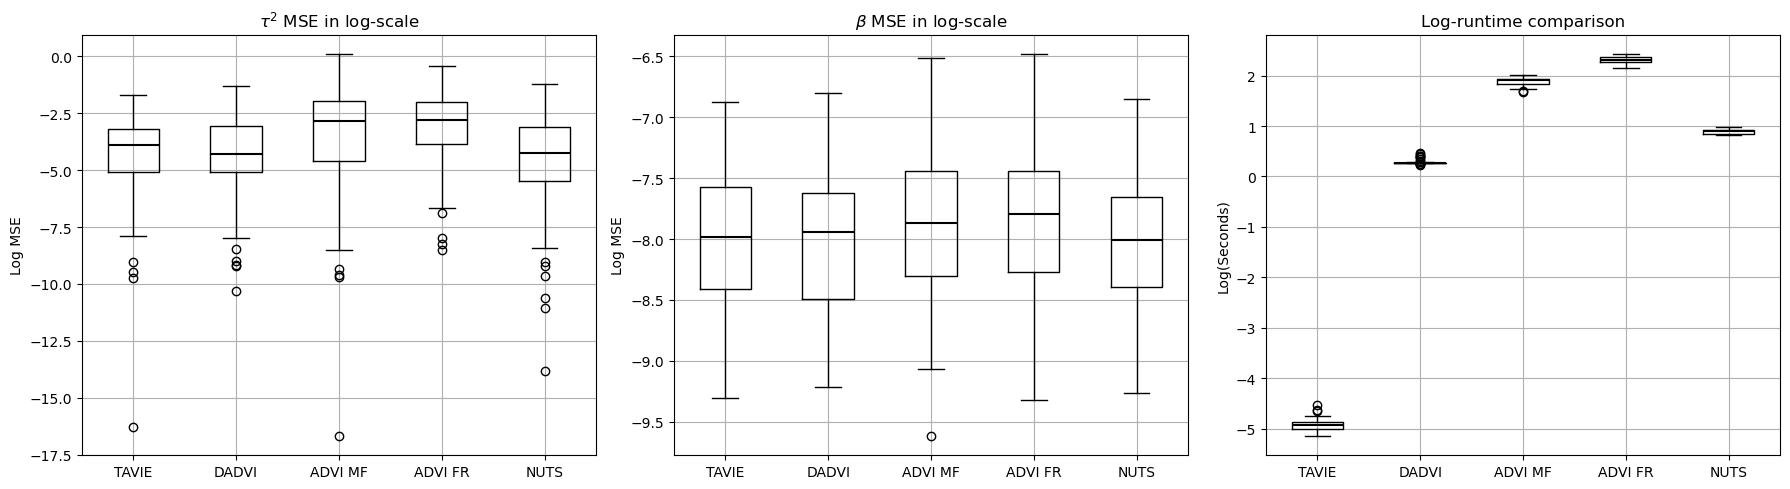

In [7]:
# plotting the results for TAVIE, DADVI, BBVI, and NUTS

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
median_kws = dict(color='black', linewidth=1.5)

# Tau^2 MSE comparison
axes[0].boxplot([np.log(mse_tau2_TAVIE), np.log(mse_tau2_DADVI), np.log(mse_tau2_ADVI_mf), np.log(mse_tau2_ADVI_fr), np.log(mse_tau2_NUTS)], 
                tick_labels=['TAVIE', 'DADVI', 'ADVI MF', 'ADVI FR', 'NUTS'], medianprops=median_kws)
axes[0].set_title(r'$\tau^2$ MSE in log-scale')
axes[0].set_ylabel('Log MSE')
axes[0].grid(True)

# Beta MSE comparison
axes[1].boxplot([np.log(mse_beta_TAVIE), np.log(mse_beta_DADVI), np.log(mse_beta_ADVI_mf), np.log(mse_beta_ADVI_fr), np.log(mse_beta_NUTS)], 
                tick_labels=['TAVIE', 'DADVI', 'ADVI MF', 'ADVI FR', 'NUTS'], medianprops=median_kws)
axes[1].set_title(r'$\beta$ MSE in log-scale')
axes[1].set_ylabel('Log MSE')
axes[1].grid(True)

# Runtime comparison
axes[2].boxplot([np.log(time_TAVIE), np.log(time_DADVI), np.log(time_ADVI_mf), np.log(time_ADVI_fr), np.log(time_NUTS)], 
                tick_labels=['TAVIE', 'DADVI', 'ADVI MF', 'ADVI FR', 'NUTS'], medianprops=median_kws)
axes[2].set_title('Log-runtime comparison')
axes[2].set_ylabel('Log(Seconds)')
axes[2].grid(True)

plt.tight_layout()
fig.savefig(f'results_compete/plots/Laplace_metrics_n_{n}_p_{p}.png', dpi=300, bbox_inches='tight')
plt.show()

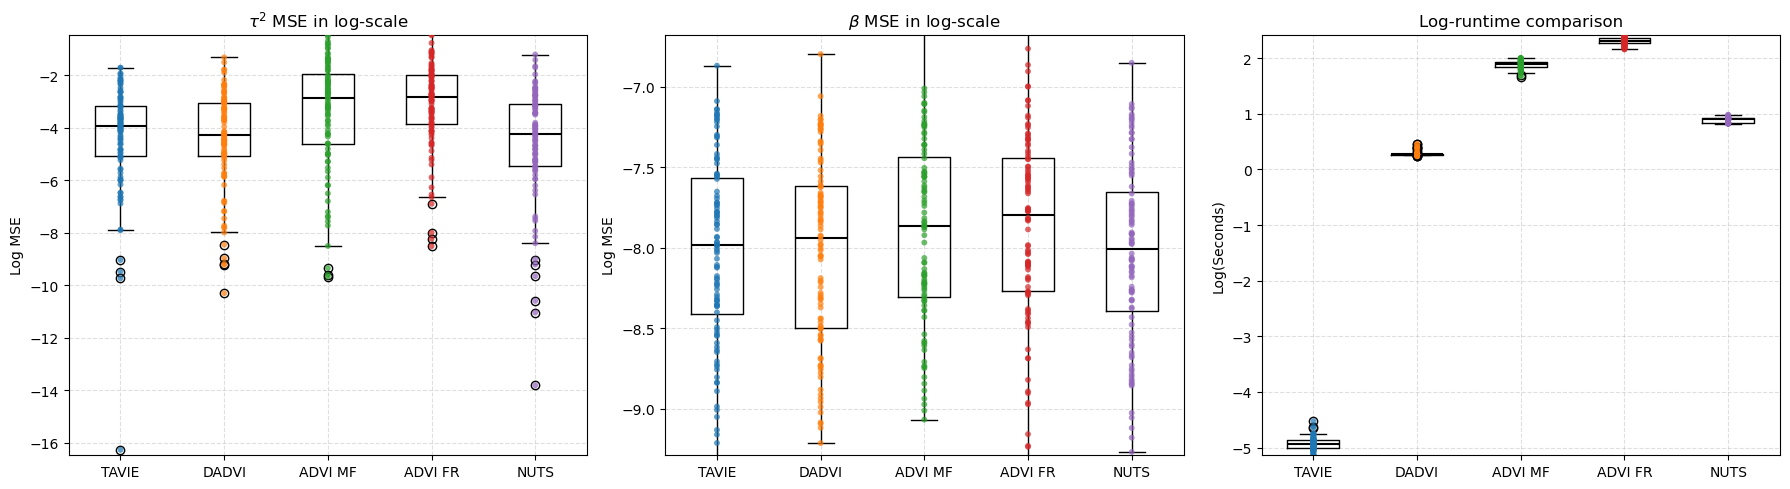

In [8]:
# plotting the results for TAVIE, DADVI, ADVI's, and NUTS

labels = ['TAVIE', 'DADVI', 'ADVI MF', 'ADVI FR', 'NUTS']
eps = 1e-16  # avoid log(0)

# prepare log-data (original values, no jitter)
tau2_logs = [np.log(np.clip(np.asarray(a), eps, None)) for a in
             [mse_tau2_TAVIE, mse_tau2_DADVI, mse_tau2_ADVI_mf, mse_tau2_ADVI_fr, mse_tau2_NUTS]]
beta_logs = [np.log(np.clip(np.asarray(a), eps, None)) for a in
             [mse_beta_TAVIE, mse_beta_DADVI, mse_beta_ADVI_mf, mse_beta_ADVI_fr, mse_beta_NUTS]]
time_logs = [np.log(np.clip(np.asarray(a), eps, None)) for a in
             [time_TAVIE, time_DADVI, time_ADVI_mf, time_ADVI_fr, time_NUTS]]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
median_kws = dict(color='black', linewidth=1.5)

# --- τ² MSE ---
axes[0].boxplot(tau2_logs, tick_labels=labels, medianprops=median_kws)
axes[0].set_title(r'$\tau^2$ MSE in log-scale')
axes[0].set_ylabel('Log MSE')
axes[0].grid(True, linestyle='--', alpha=0.4)
for i, y in enumerate(tau2_logs, start=1):
    x = np.full(y.shape, i, dtype=float)  # exact category center, no jitter
    axes[0].scatter(x, y, s=18, alpha=0.7, zorder=3, edgecolors='none')

# --- β MSE ---
axes[1].boxplot(beta_logs, tick_labels=labels, medianprops=median_kws)
axes[1].set_title(r'$\beta$ MSE in log-scale')
axes[1].set_ylabel('Log MSE')
axes[1].grid(True, linestyle='--', alpha=0.4)
for i, y in enumerate(beta_logs, start=1):
    x = np.full(y.shape, i, dtype=float)
    axes[1].scatter(x, y, s=18, alpha=0.7, zorder=3, edgecolors='none')

# --- Runtime ---
axes[2].boxplot(time_logs, tick_labels=labels, medianprops=median_kws)
axes[2].set_title('Log-runtime comparison')
axes[2].set_ylabel('Log(Seconds)')
axes[2].grid(True, linestyle='--', alpha=0.4)
for i, y in enumerate(time_logs, start=1):
    x = np.full(y.shape, i, dtype=float)
    axes[2].scatter(x, y, s=18, alpha=0.7, zorder=3, edgecolors='none')

# optional: robust y-limits so tiny spreads aren’t crushed by outliers
for ax, logs in zip(axes, [tau2_logs, beta_logs, time_logs]):
    allv = np.concatenate([v for v in logs if len(v)])
    ax.set_ylim(*np.percentile(allv, [0.5, 99.5]))

plt.tight_layout()
fig.savefig(f'results_compete/plots/Laplace_metrics_n_{n}_p_{p}_other.png', dpi=300, bbox_inches='tight')
plt.show()


### For multiple sample sizes n and fixed features p=5

In [9]:
# ==== Experiment settings ====
p = 5
tau2_true = 3.0
num_reps = 100
sample_sizes = [200, 500, 1000, 2000]     # <-- your various n’s here

# True beta vector
beta_true = np.random.normal(loc=0.0, scale=1.0, size=p+1)

# Prior for full‐cov BBVI
Sigma_prior = np.eye(p + 1)
a, b = 0.025, 0.025

# Pre‐allocate storage: shape (len(sample_sizes), num_reps)
n_sizes = len(sample_sizes)
mse_beta_TAVIE          = np.zeros((n_sizes, num_reps))
mse_tau2_TAVIE          = np.zeros((n_sizes, num_reps))
time_TAVIE              = np.zeros((n_sizes, num_reps))

mse_beta_DADVI          = np.zeros((n_sizes, num_reps))
mse_tau2_DADVI          = np.zeros((n_sizes, num_reps))
time_DADVI              = np.zeros((n_sizes, num_reps))

mse_beta_NUTS          = np.zeros((n_sizes, num_reps))
mse_tau2_NUTS          = np.zeros((n_sizes, num_reps))
time_NUTS              = np.zeros((n_sizes, num_reps))

mse_beta_ADVI_mf           = np.zeros((n_sizes, num_reps))
mse_tau2_ADVI_mf           = np.zeros((n_sizes, num_reps))
time_ADVI_mf               = np.zeros((n_sizes, num_reps))

mse_beta_ADVI_fr   = np.zeros((n_sizes, num_reps))
mse_tau2_ADVI_fr   = np.zeros((n_sizes, num_reps))
time_ADVI_fr       = np.zeros((n_sizes, num_reps))

# Initialize TAVIE once
laplace_tavie_model = TAVIE_loc_scale(family="laplace", fit_intercept=True)

# ==== Main loops ====
for i, n in enumerate(sample_sizes):
    for rep in trange(num_reps, desc=f"n={n}"):
        np.random.seed(rep)
        # 1) Simulate data
        X = np.random.normal(size=(n, p))
        X_bbvi = np.column_stack([np.ones(n), X])
        error = np.random.laplace(loc=0.0, scale=1/np.sqrt(tau2_true), size=n)
        y = X_bbvi @ beta_true + error

        # ---- TAVIE ----
        t0 = perf_counter()
        laplace_tavie_model.fit(X, y, verbose=False)
        time_TAVIE[i, rep] = perf_counter() - t0
        beta_est_TAVIE, tau2_est_TAVIE = laplace_tavie_model.get_TAVIE_means(verbose=False)
        mse_beta_TAVIE[i, rep] = np.mean((beta_est_TAVIE - beta_true)**2)
        mse_tau2_TAVIE[i, rep] = (tau2_est_TAVIE - tau2_true)**2

        # DADVI estimator
        laplace_dadvi_model = laplace_pymc_model(X_bbvi, y)
        t0 = perf_counter()
        laplace_dadvi_res = fit_pymc_dadvi_with_jax(laplace_dadvi_model, num_fixed_draws=30).get_posterior_means()
        time_DADVI[i, rep] = perf_counter() - t0
        beta_est_DADVI = laplace_dadvi_res['beta']
        tau2_est_DADVI = np.exp(laplace_dadvi_res['tau2_log__'])
        mse_beta_DADVI[i, rep] = np.mean((beta_est_DADVI - beta_true)**2)
        mse_tau2_DADVI[i, rep] = (tau2_est_DADVI - tau2_true)**2
    
        # NUTS estimator
        t0 = perf_counter()
        laplace_nuts_res = fit_NUTS_laplace(laplace_dadvi_model)
        time_NUTS[i, rep] = perf_counter() - t0
        beta_est_NUTS = laplace_nuts_res['beta']
        tau2_est_NUTS = laplace_nuts_res['tau2']
        mse_beta_NUTS[i, rep] = np.mean((beta_est_NUTS - beta_true)**2)
        mse_tau2_NUTS[i, rep] = (tau2_est_NUTS - tau2_true)**2

        # ---- ADVI mean-field ----
        t0 = perf_counter()
        res_diag = BBVI_Laplace_patience_best(
            X_bbvi, y,
            a=a, b=b,
            lr=1e-3,
            tol=1e-9,
            patience=1e4,
            verbose=False
        )
        time_ADVI_mf[i, rep] = perf_counter() - t0
        beta_d = res_diag['beta_mean']
        tau2_d = res_diag['tau2_mean']
        mse_beta_ADVI_mf[i, rep] = np.mean((beta_d - beta_true)**2)
        mse_tau2_ADVI_mf[i, rep] = (tau2_d - tau2_true)**2

        # ---- ADVI full-rank ----
        t0 = perf_counter()
        res_full = BBVI_Laplace_fullcov_AdamW_best(
            X_bbvi, y,
            Sigma_prior=Sigma_prior,
            a=a, b=b,
            lr=1e-3,
            tol=1e-9,
            patience=1e4,
            verbose=False
        )
        time_ADVI_fr[i, rep] = perf_counter() - t0

        beta_f = res_full['beta_mean']
        tau2_f = res_full['tau2_mean']
        mse_beta_ADVI_fr[i, rep] = np.mean((beta_f - beta_true)**2)
        mse_tau2_ADVI_fr[i, rep] = (tau2_f - tau2_true)**2

# saving the metrics
import pickle

# collect everything into a single dict
metrics_df = {
    'p'            :       p,
    'n'            :       sample_sizes,
    'mse_beta_TAVIE':     mse_beta_TAVIE,
    'mse_tau2_TAVIE':     mse_tau2_TAVIE,
    'time_TAVIE':         time_TAVIE,
    'mse_beta_ADVI_mf':      mse_beta_ADVI_mf,
    'mse_tau2_ADVI_mf':      mse_tau2_ADVI_mf,
    'time_ADVI_mf':          time_ADVI_mf,
    'mse_beta_ADVI_fr':      mse_beta_ADVI_fr,
    'mse_tau2_ADVI_fr':      mse_tau2_ADVI_fr,
    'time_ADVI_fr':          time_ADVI_fr,
    'mse_beta_DADVI':      mse_beta_DADVI,
    'mse_tau2_DADVI':      mse_tau2_DADVI,
    'time_DADVI':          time_DADVI,
    'mse_beta_NUTS':      mse_beta_NUTS,
    'mse_tau2_NUTS':      mse_tau2_NUTS,
    'time_NUTS':          time_NUTS,
}

# write to disk
with open(f'results_compete/Laplace_metrics_multi_n_p_{p}.pkl', 'wb') as f:
    pickle.dump(metrics_df, f, protocol=pickle.HIGHEST_PROTOCOL)

n=2000: 100%|██████████████████████████| 100/100 [38:18<00:00, 22.99s/it]


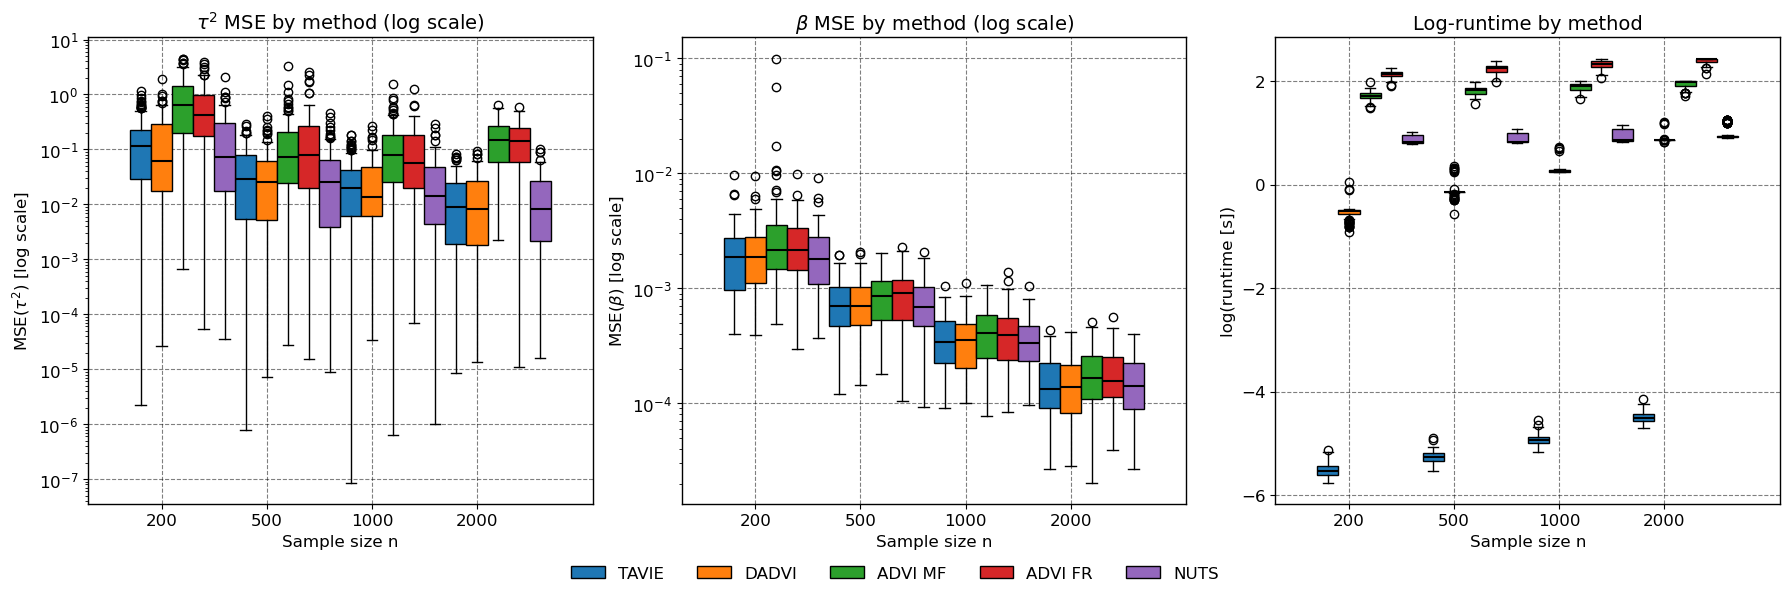

In [10]:
# plotting the results for TAVIE, DADVI, ADVI, and NUTS over the choice of different sample sizes n

methods  = ['TAVIE', 'DADVI', 'ADVI MF', 'ADVI FR', 'NUTS']
colors   = ['C0',    'C1',    'C2', 'C3', 'C4']
n_sizes  = len(sample_sizes)
x        = np.arange(n_sizes)
width    = 0.2

fig, axes = plt.subplots(1, 3, figsize=(18, 6), facecolor='white')
median_kws = dict(color='black', linewidth=1.5)

# Configure axes background, spines, ticks, and grid
for ax in axes:
    ax.set_facecolor('white')
    for spine in ax.spines.values():
        spine.set_color('black')
        spine.set_linewidth(1.0)
    ax.tick_params(axis='both', colors='black', labelsize=12)
    ax.grid(True, color='black', linestyle='--', alpha=0.5)

# 1) τ² MSE (log scale)
ax = axes[0]
for j, arr in enumerate([mse_tau2_TAVIE, mse_tau2_DADVI, mse_tau2_ADVI_mf, mse_tau2_ADVI_fr, mse_tau2_NUTS]):
    data = [arr[i, :] for i in range(n_sizes)]
    positions = x + (j-1)*width
    bp = ax.boxplot(data, positions=positions, widths=width, patch_artist=True, medianprops=median_kws)
    for box in bp['boxes']:
        box.set(facecolor=colors[j], edgecolor='black')
ax.set_xticks(x)
ax.set_xticklabels(sample_sizes)
ax.set_yscale('log')
ax.set_xlabel('Sample size n', color='black', fontsize=12)
ax.set_ylabel(r'MSE($\tau^2$) [log scale]', color='black', fontsize=12)
ax.set_title(r'$\tau^2$ MSE by method (log scale)', color='black', fontsize=14)

# 2) β MSE (log scale)
ax = axes[1]
for j, arr in enumerate([mse_beta_TAVIE, mse_beta_DADVI, mse_beta_ADVI_mf, mse_beta_ADVI_fr, mse_beta_NUTS]):
    data = [arr[i, :] for i in range(n_sizes)]
    positions = x + (j-1)*width
    bp = ax.boxplot(data, positions=positions, widths=width,
                    patch_artist=True, medianprops=median_kws)
    for box in bp['boxes']:
        box.set(facecolor=colors[j], edgecolor='black')
ax.set_xticks(x)
ax.set_xticklabels(sample_sizes)
ax.set_yscale('log')
ax.set_xlabel('Sample size n', color='black', fontsize=12)
ax.set_ylabel(r'MSE($\beta$) [log scale]', color='black', fontsize=12)
ax.set_title(r'$\beta$ MSE by method (log scale)', color='black', fontsize=14)

# 3) Runtime (log scale)
ax = axes[2]
for j, arr in enumerate([time_TAVIE, time_DADVI, time_ADVI_mf, time_ADVI_fr, time_NUTS]):
    data = [np.log(arr[i, :]) for i in range(n_sizes)]
    positions = x + (j-1)*width
    bp = ax.boxplot(data, positions=positions, widths=width, patch_artist=True, medianprops=median_kws)
    for box in bp['boxes']:
        box.set(facecolor=colors[j], edgecolor='black')
ax.set_xticks(x)
ax.set_xticklabels(sample_sizes)
ax.set_xlabel('Sample size n', color='black', fontsize=12)
ax.set_ylabel('log(runtime [s])', color='black', fontsize=12)
ax.set_title('Log-runtime by method', color='black', fontsize=14)

# Common legend below
handles = [
    Patch(facecolor=colors[i], edgecolor='black', label=methods[i])
    for i in range(len(methods))
]
fig.legend(handles=handles,
           loc='lower center',
           ncol=5,
           frameon=False,
           fontsize=12)

plt.tight_layout(rect=[0, 0.05, 1, 1])
fig.savefig(f'results_compete/plots/Laplace_metrics_multi_n_p_{p}.png', dpi=300, bbox_inches='tight')
plt.show()

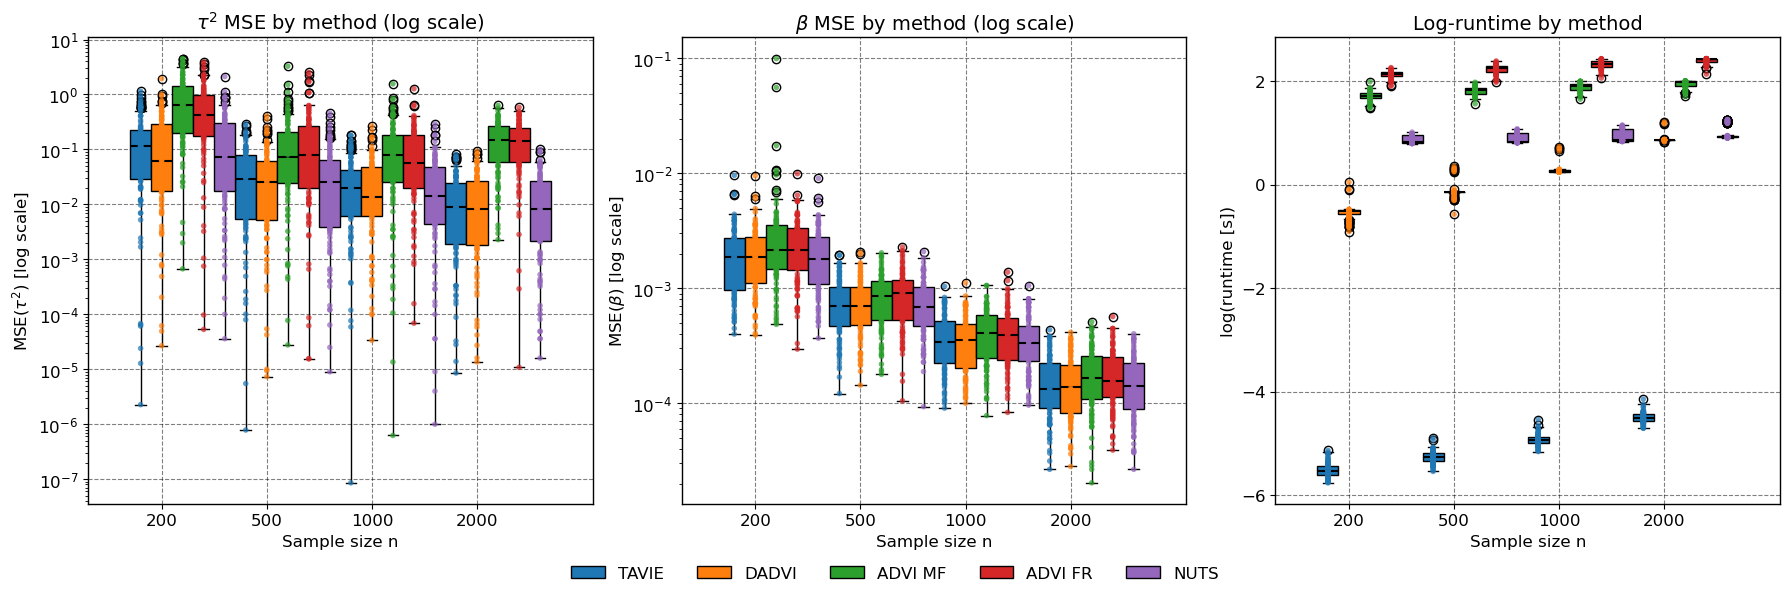

In [11]:
# plotting the results for TAVIE, DADVI, ADVI, and NUTS over different sample sizes n

methods  = ['TAVIE', 'DADVI', 'ADVI MF', 'ADVI FR', 'NUTS']
colors   = ['C0',    'C1',    'C2',      'C3',      'C4']
n_sizes  = len(sample_sizes)
x        = np.arange(n_sizes)
width    = 0.2
eps      = 1e-16  # avoid log(0) for the log-scale panels

fig, axes = plt.subplots(1, 3, figsize=(18, 6), facecolor='white')
median_kws = dict(color='black', linewidth=1.5)

# Configure axes background, spines, ticks, and grid
for ax in axes:
    ax.set_facecolor('white')
    for spine in ax.spines.values():
        spine.set_color('black')
        spine.set_linewidth(1.0)
    ax.tick_params(axis='both', colors='black', labelsize=12)
    ax.grid(True, color='black', linestyle='--', alpha=0.5)

# 1) τ² MSE (log scale)
ax = axes[0]
for j, arr in enumerate([mse_tau2_TAVIE, mse_tau2_DADVI, mse_tau2_ADVI_mf, mse_tau2_ADVI_fr, mse_tau2_NUTS]):
    data = [arr[i, :] for i in range(n_sizes)]
    positions = x + (j-1)*width
    bp = ax.boxplot(data, positions=positions, widths=width, patch_artist=True, medianprops=median_kws)
    for box in bp['boxes']:
        box.set(facecolor=colors[j], edgecolor='black')

    # overlay original values (no jitter)
    for i in range(n_sizes):
        pos = positions[i]
        yvals = np.asarray(arr[i, :])
        ax.scatter(np.full_like(yvals, pos, dtype=float), yvals, s=16, alpha=0.7, color=colors[j], zorder=3, edgecolors='none')

ax.set_xticks(x)
ax.set_xticklabels(sample_sizes)
ax.set_yscale('log')
ax.set_xlabel('Sample size n', color='black', fontsize=12)
ax.set_ylabel(r'MSE($\tau^2$) [log scale]', color='black', fontsize=12)
ax.set_title(r'$\tau^2$ MSE by method (log scale)', color='black', fontsize=14)

# 2) β MSE (log scale)
ax = axes[1]
for j, arr in enumerate([mse_beta_TAVIE, mse_beta_DADVI, mse_beta_ADVI_mf, mse_beta_ADVI_fr, mse_beta_NUTS]):
    data = [np.clip(arr[i, :], eps, None) for i in range(n_sizes)]  # ensure >0 for log axis
    positions = x + (j-1)*width
    bp = ax.boxplot(data, positions=positions, widths=width, patch_artist=True, medianprops=median_kws)
    for box in bp['boxes']:
        box.set(facecolor=colors[j], edgecolor='black')

    # overlay original (clipped) values (no jitter)
    for i in range(n_sizes):
        pos = positions[i]
        yvals = np.clip(np.asarray(arr[i, :]), eps, None)
        ax.scatter(np.full_like(yvals, pos, dtype=float), yvals, s=16, alpha=0.7, color=colors[j], zorder=3, edgecolors='none')

ax.set_xticks(x)
ax.set_xticklabels(sample_sizes)
ax.set_yscale('log')
ax.set_xlabel('Sample size n', color='black', fontsize=12)
ax.set_ylabel(r'MSE($\beta$) [log scale]', color='black', fontsize=12)
ax.set_title(r'$\beta$ MSE by method (log scale)', color='black', fontsize=14)

# 3) Runtime (log scale on the DATA)
ax = axes[2]
for j, arr in enumerate([time_TAVIE, time_DADVI, time_ADVI_mf, time_ADVI_fr, time_NUTS]):
    data = [np.log(np.clip(arr[i, :], eps, None)) for i in range(n_sizes)]
    positions = x + (j-1)*width
    bp = ax.boxplot(data, positions=positions, widths=width, patch_artist=True, medianprops=median_kws)
    for box in bp['boxes']:
        box.set(facecolor=colors[j], edgecolor='black')

    # overlay log-values (no jitter)
    for i in range(n_sizes):
        pos = positions[i]
        yvals = np.log(np.clip(np.asarray(arr[i, :]), eps, None))
        ax.scatter(np.full_like(yvals, pos, dtype=float), yvals, s=16, alpha=0.7, color=colors[j], zorder=3, edgecolors='none')

ax.set_xticks(x)
ax.set_xticklabels(sample_sizes)
ax.set_xlabel('Sample size n', color='black', fontsize=12)
ax.set_ylabel('log(runtime [s])', color='black', fontsize=12)
ax.set_title('Log-runtime by method', color='black', fontsize=14)

# Common legend below
handles = [Patch(facecolor=colors[i], edgecolor='black', label=methods[i]) for i in range(len(methods))]
fig.legend(handles=handles, loc='lower center', ncol=5, frameon=False, fontsize=12)

plt.tight_layout(rect=[0, 0.05, 1, 1])
fig.savefig(f'results_compete/plots/Laplace_metrics_multi_n_p_{p}_other.png', dpi=300, bbox_inches='tight')
plt.show()

### For multiple number of features p and fixed sample size n=1000

In [12]:
# ==== Experiment settings ====
n = 1000
p_values   = [3, 4, 5, 6]
tau2_true  = 3.0
num_reps   = 100

# Hyperparameters for BBVI full‐covariances
a, b = 0.025, 0.025

# Pre‐allocate storage
P = len(p_values)
mse_beta_TAVIE        = np.zeros((P, num_reps))
mse_tau2_TAVIE        = np.zeros((P, num_reps))
time_TAVIE            = np.zeros((P, num_reps))

mse_beta_DADVI        = np.zeros((P, num_reps))
mse_tau2_DADVI        = np.zeros((P, num_reps))
time_DADVI            = np.zeros((P, num_reps))

mse_beta_NUTS        = np.zeros((P, num_reps))
mse_tau2_NUTS        = np.zeros((P, num_reps))
time_NUTS            = np.zeros((P, num_reps))

mse_beta_ADVI_mf         = np.zeros((P, num_reps))
mse_tau2_ADVI_mf         = np.zeros((P, num_reps))
time_ADVI_mf             = np.zeros((P, num_reps))

mse_beta_ADVI_fr = np.zeros((P, num_reps))
mse_tau2_ADVI_fr = np.zeros((P, num_reps))
time_ADVI_fr     = np.zeros((P, num_reps))

# ==== Main loops over p and replicates ====
for i, p in enumerate(p_values):
    # Prior covariance for BBVI full-cov
    Sigma_prior = np.eye(p + 1)

    # Initialize TAVIE model once for this p
    laplace_tavie_model = TAVIE_loc_scale(family="laplace", fit_intercept=True)

    # Draw a fixed "true" beta for this p
    beta_true = np.random.normal(loc=0.0, scale=1.0, size=p+1)

    for rep in trange(num_reps, desc=f"p={p}"):
        np.random.seed(rep)
        # 1) Simulate data
        X      = np.random.normal(size=(n, p))
        X_bbvi = np.column_stack([np.ones(n), X])
        error  = np.random.laplace(loc=0.0, scale=1/np.sqrt(tau2_true), size=n)
        y      = X_bbvi @ beta_true + error

        # ---- TAVIE ----
        t0 = perf_counter()
        laplace_tavie_model.fit(X, y, verbose=False)
        time_TAVIE[i, rep] = perf_counter() - t0
        beta_est_TAVIE, tau2_est_TAVIE = laplace_tavie_model.get_TAVIE_means(verbose=False)
        mse_beta_TAVIE[i, rep] = np.mean((beta_est_TAVIE - beta_true)**2)
        mse_tau2_TAVIE[i, rep] = (tau2_est_TAVIE - tau2_true)**2

        # DADVI estimator
        laplace_dadvi_model = laplace_pymc_model(X_bbvi, y)
        t0 = perf_counter()
        laplace_dadvi_res = fit_pymc_dadvi_with_jax(laplace_dadvi_model, num_fixed_draws=30).get_posterior_means()
        time_DADVI[i, rep] = perf_counter() - t0
        beta_est_DADVI = laplace_dadvi_res['beta']
        tau2_est_DADVI = np.exp(laplace_dadvi_res['tau2_log__'])
        mse_beta_DADVI[i, rep] = np.mean((beta_est_DADVI - beta_true)**2)
        mse_tau2_DADVI[i, rep] = (tau2_est_DADVI - tau2_true)**2
    
        # NUTS estimator
        t0 = perf_counter()
        laplace_nuts_res = fit_NUTS_laplace(laplace_dadvi_model)
        time_NUTS[i, rep] = perf_counter() - t0
        beta_est_NUTS = laplace_nuts_res['beta']
        tau2_est_NUTS = laplace_nuts_res['tau2']
        mse_beta_NUTS[i, rep] = np.mean((beta_est_NUTS - beta_true)**2)
        mse_tau2_NUTS[i, rep] = (tau2_est_NUTS - tau2_true)**2

        # ---- ADVI mean-field ----
        t0 = perf_counter()
        res_diag = BBVI_Laplace_patience_best(
            X_bbvi, y,
            a=a, b=b,
            lr=1e-3,
            tol=1e-9,
            patience=1e4,
            verbose=False
        )
        time_ADVI_mf[i, rep] = perf_counter() - t0
        beta_d = res_diag['beta_mean']
        tau2_d = res_diag['tau2_mean']
        mse_beta_ADVI_mf[i, rep] = np.mean((beta_d - beta_true)**2)
        mse_tau2_ADVI_mf[i, rep] = (tau2_d - tau2_true)**2

        # ---- ADVI full-rank ----
        t0 = perf_counter()
        res_full = BBVI_Laplace_fullcov_AdamW_best(
            X_bbvi, y,
            Sigma_prior=Sigma_prior,
            a=a, b=b,
            lr=1e-3,
            tol=1e-9,
            patience=1e4,
            verbose=False
        )
        time_ADVI_fr[i, rep] = perf_counter() - t0

        beta_f = res_full['beta_mean']
        tau2_f = res_full['tau2_mean']
        mse_beta_ADVI_fr[i, rep] = np.mean((beta_f - beta_true)**2)
        mse_tau2_ADVI_fr[i, rep] = (tau2_f - tau2_true)**2

# saving the metrics
import pickle

# collect everything into a single dict
metrics_df = {
    'p'            :      p_values,
    'n'            :      n,
    'mse_beta_TAVIE':     mse_beta_TAVIE,
    'mse_tau2_TAVIE':     mse_tau2_TAVIE,
    'time_TAVIE':         time_TAVIE,
    'mse_beta_ADVI_mf':      mse_beta_ADVI_mf,
    'mse_tau2_ADVI_mf':      mse_tau2_ADVI_mf,
    'time_ADVI_mf':          time_ADVI_mf,
    'mse_beta_ADVI_fr':      mse_beta_ADVI_fr,
    'mse_tau2_ADVI_fr':      mse_tau2_ADVI_fr,
    'time_ADVI_fr':          time_ADVI_fr,
    'mse_beta_DADVI':      mse_beta_DADVI,
    'mse_tau2_DADVI':      mse_tau2_DADVI,
    'time_DADVI':          time_DADVI,
    'mse_beta_NUTS':      mse_beta_NUTS,
    'mse_tau2_NUTS':      mse_tau2_NUTS,
    'time_NUTS':          time_NUTS,
}

# write to disk
with open(f'results_compete/Laplace_metrics_multi_p_n_{n}.pkl', 'wb') as f:
    pickle.dump(metrics_df, f, protocol=pickle.HIGHEST_PROTOCOL)

p=6: 100%|█████████████████████████████| 100/100 [36:08<00:00, 21.68s/it]


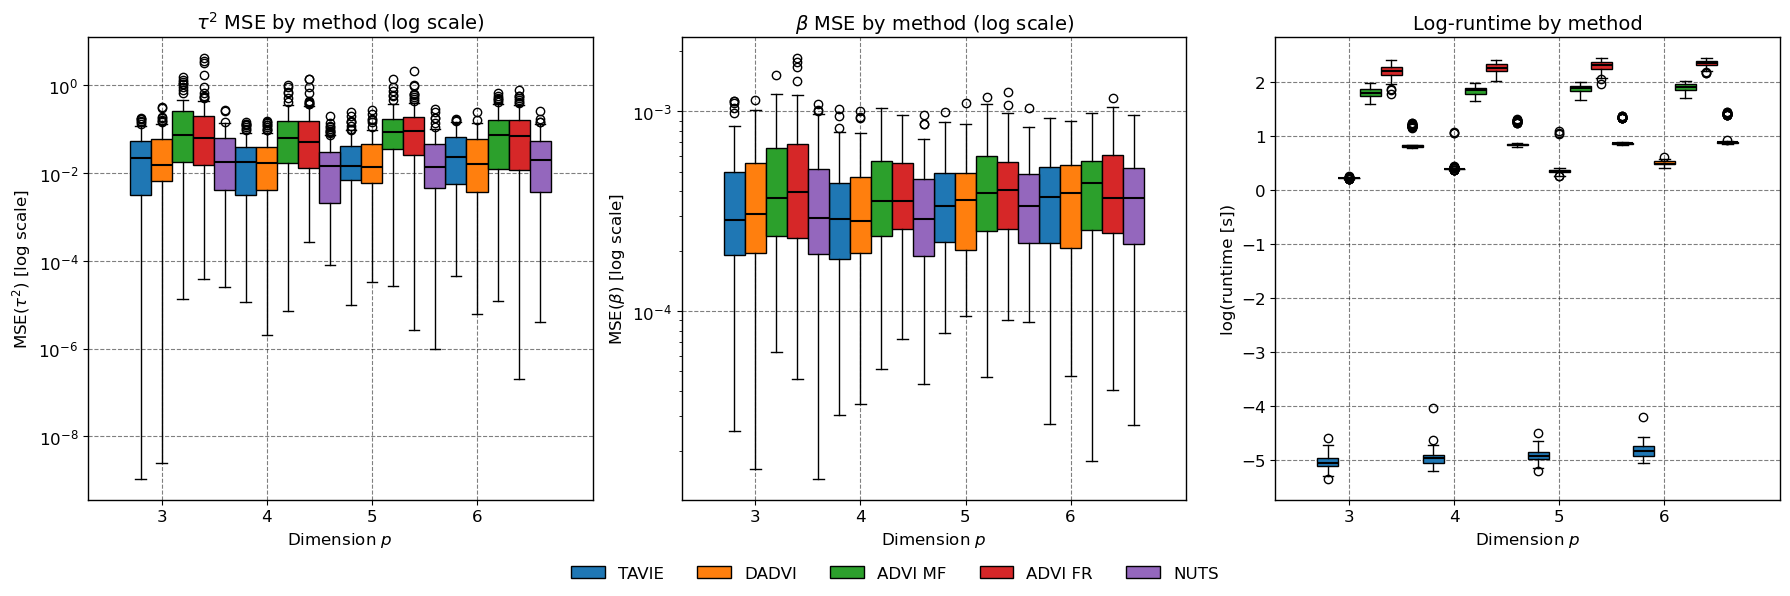

In [13]:
# plotting the results for TAVIE and competing methods over the choice of features p

methods   = ['TAVIE', 'DADVI', 'ADVI MF', 'ADVI FR', 'NUTS']
colors    = ['C0',    'C1',    'C2', 'C3', 'C4']
P         = len(p_values)
x         = np.arange(P)
width     = 0.2

fig, axes = plt.subplots(1, 3, figsize=(18, 6), facecolor='white')
median_kws = dict(color='black', linewidth=1.5)

# Configure axes spines, ticks, grid
for ax in axes:
    ax.set_facecolor('white')
    for spine in ax.spines.values():
        spine.set_color('black')
        spine.set_linewidth(1.0)
    ax.tick_params(axis='both', colors='black', labelsize=12)
    ax.grid(True, color='black', linestyle='--', alpha=0.5)

# 1) τ² MSE (linear scale)
ax = axes[0]
for j, arr in enumerate([mse_tau2_TAVIE, mse_tau2_DADVI, mse_tau2_ADVI_mf, mse_tau2_ADVI_fr, mse_tau2_NUTS]):
    data = [arr[i, :] for i in range(P)]
    positions = x + (j-1)*width
    bp = ax.boxplot(data, positions=positions, widths=width, patch_artist=True, medianprops=median_kws)
    for box in bp['boxes']:
        box.set(facecolor=colors[j], edgecolor='black')
ax.set_xticks(x)
ax.set_xticklabels(p_values)
ax.set_yscale('log')
ax.set_xlabel('Dimension $p$', color='black', fontsize=12)
ax.set_ylabel(r'MSE($\tau^2$) [log scale]', color='black', fontsize=12)
ax.set_title(r'$\tau^2$ MSE by method (log scale)', color='black', fontsize=14)

# 2) β MSE (log scale)
ax = axes[1]
for j, arr in enumerate([mse_beta_TAVIE, mse_beta_DADVI, mse_beta_ADVI_mf, mse_beta_ADVI_fr, mse_beta_NUTS]):
    data = [arr[i, :] for i in range(P)]
    positions = x + (j-1)*width
    bp = ax.boxplot(data, positions=positions, widths=width,
                    patch_artist=True, medianprops=median_kws)
    for box in bp['boxes']:
        box.set(facecolor=colors[j], edgecolor='black')
ax.set_xticks(x)
ax.set_xticklabels(p_values)
ax.set_yscale('log')
ax.set_xlabel('Dimension $p$', color='black', fontsize=12)
ax.set_ylabel(r'MSE($\beta$) [log scale]', color='black', fontsize=12)
ax.set_title(r'$\beta$ MSE by method (log scale)', color='black', fontsize=14)

# 3) Runtime (log scale)
ax = axes[2]
for j, arr in enumerate([time_TAVIE, time_DADVI, time_ADVI_mf, time_ADVI_fr, time_NUTS]):
    data = [np.log(arr[i, :]) for i in range(P)]
    positions = x + (j-1)*width
    bp = ax.boxplot(data, positions=positions, widths=width, patch_artist=True, medianprops=median_kws)
    for box in bp['boxes']:
        box.set(facecolor=colors[j], edgecolor='black')
ax.set_xticks(x)
ax.set_xticklabels(p_values)
ax.set_xlabel('Dimension $p$', color='black', fontsize=12)
ax.set_ylabel('log(runtime [s])', color='black', fontsize=12)
ax.set_title('Log-runtime by method', color='black', fontsize=14)

# Common legend below
handles = [
    Patch(facecolor=colors[i], edgecolor='black', label=methods[i])
    for i in range(len(methods))
]
fig.legend(handles=handles,
           loc='lower center',
           ncol=5,
           frameon=False,
           fontsize=12)

plt.tight_layout(rect=[0, 0.05, 1, 1])
fig.savefig(f'results_compete/plots/Laplace_metrics_multi_p_n_{n}.png', dpi=300, bbox_inches='tight')
plt.show()

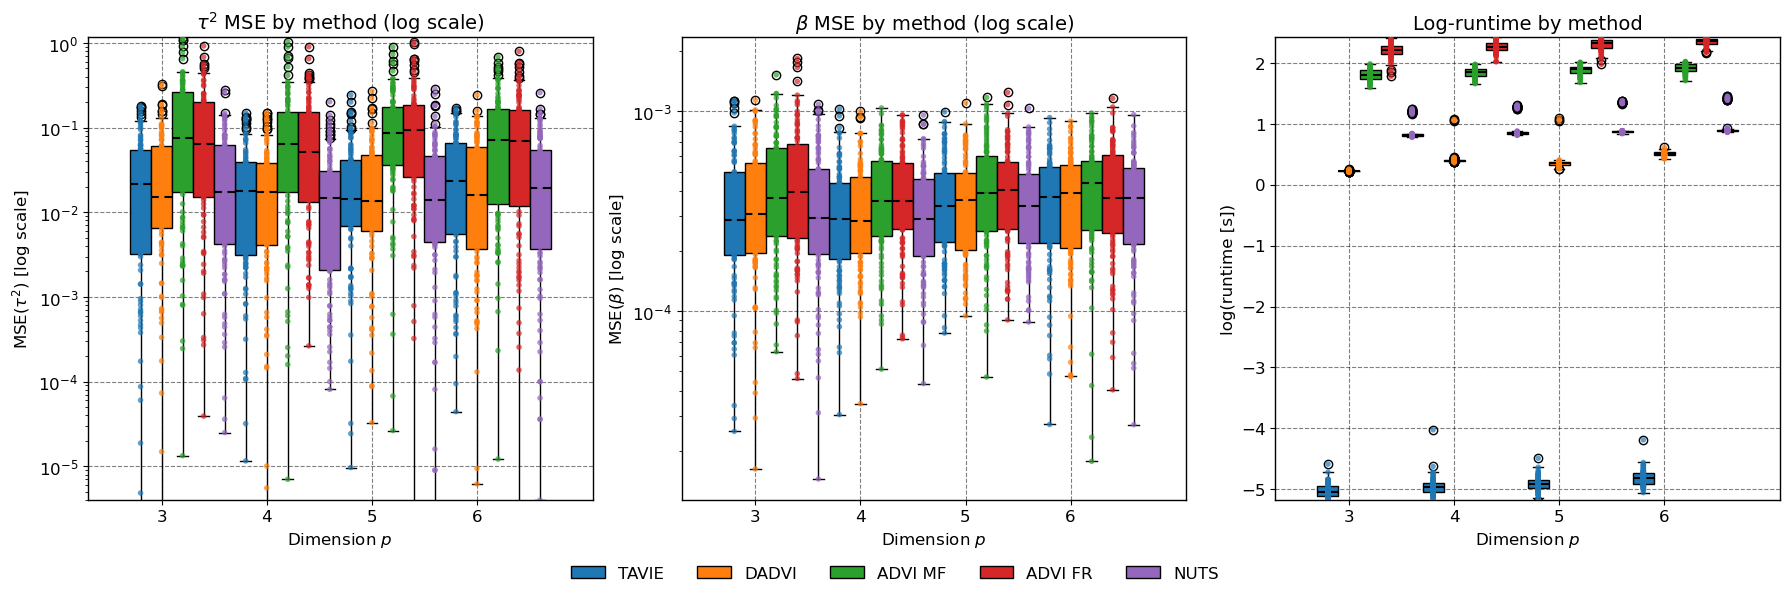

In [14]:
# plotting the results for TAVIE and competing methods over the choice of features p

methods   = ['TAVIE', 'DADVI', 'ADVI MF', 'ADVI FR', 'NUTS']
colors    = ['C0',    'C1',    'C2',      'C3',      'C4']
P         = len(p_values)
x         = np.arange(P)
width     = 0.2
eps       = 1e-16  # avoid log(0) in log-scale panels

fig, axes = plt.subplots(1, 3, figsize=(18, 6), facecolor='white')
median_kws = dict(color='black', linewidth=1.5)

# Configure axes spines, ticks, grid
for ax in axes:
    ax.set_facecolor('white')
    for spine in ax.spines.values():
        spine.set_color('black')
        spine.set_linewidth(1.0)
    ax.tick_params(axis='both', colors='black', labelsize=12)
    ax.grid(True, color='black', linestyle='--', alpha=0.5)

# 1) τ² MSE (log scale)
ax = axes[0]
all_vals_tau2 = []
for j, arr in enumerate([mse_tau2_TAVIE, mse_tau2_DADVI, mse_tau2_ADVI_mf, mse_tau2_ADVI_fr, mse_tau2_NUTS]):
    data = [arr[i, :] for i in range(P)]
    positions = x + (j-1)*width
    bp = ax.boxplot(data, positions=positions, widths=width,
                    patch_artist=True, medianprops=median_kws)
    for box in bp['boxes']:
        box.set(facecolor=colors[j], edgecolor='black')
    # overlay original values (no jitter)
    for i in range(P):
        pos = positions[i]
        yvals = np.asarray(arr[i, :])
        ax.scatter(np.full_like(yvals, pos, dtype=float), yvals,
                   s=16, alpha=0.7, color=colors[j], zorder=3, edgecolors='none')
        all_vals_tau2.append(yvals)

ax.set_xticks(x)
ax.set_xticklabels(p_values)
ax.set_yscale('log')
ax.set_xlabel('Dimension $p$', color='black', fontsize=12)
ax.set_ylabel(r'MSE($\tau^2$) [log scale]', color='black', fontsize=12)
ax.set_title(r'$\tau^2$ MSE by method (log scale)', color='black', fontsize=14)
# Optional robust limits
all_vals_tau2 = np.concatenate(all_vals_tau2) if len(all_vals_tau2) else np.array([0,1])
ax.set_ylim(*np.percentile(all_vals_tau2, [0.5, 99.5]))

# 2) β MSE (log scale axis; data must be >0)
ax = axes[1]
all_vals_beta = []
for j, arr in enumerate([mse_beta_TAVIE, mse_beta_DADVI, mse_beta_ADVI_mf, mse_beta_ADVI_fr, mse_beta_NUTS]):
    data = [np.clip(arr[i, :], eps, None) for i in range(P)]
    positions = x + (j-1)*width
    bp = ax.boxplot(data, positions=positions, widths=width,
                    patch_artist=True, medianprops=median_kws)
    for box in bp['boxes']:
        box.set(facecolor=colors[j], edgecolor='black')
    # overlay original values (clipped) (no jitter)
    for i in range(P):
        pos = positions[i]
        yvals = np.clip(np.asarray(arr[i, :]), eps, None)
        ax.scatter(np.full_like(yvals, pos, dtype=float), yvals,
                   s=16, alpha=0.7, color=colors[j], zorder=3, edgecolors='none')
        all_vals_beta.append(yvals)

ax.set_xticks(x)
ax.set_xticklabels(p_values)
ax.set_yscale('log')
ax.set_xlabel('Dimension $p$', color='black', fontsize=12)
ax.set_ylabel(r'MSE($\beta$) [log scale]', color='black', fontsize=12)
ax.set_title(r'$\beta$ MSE by method (log scale)', color='black', fontsize=14)
# Optional robust limits in log space handled by axis scaling & box stats

# 3) Runtime (log on the DATA; axis stays linear)
ax = axes[2]
all_vals_time = []
for j, arr in enumerate([time_TAVIE, time_DADVI, time_ADVI_mf, time_ADVI_fr, time_NUTS]):
    data = [np.log(np.clip(arr[i, :], eps, None)) for i in range(P)]
    positions = x + (j-1)*width
    bp = ax.boxplot(data, positions=positions, widths=width,
                    patch_artist=True, medianprops=median_kws)
    for box in bp['boxes']:
        box.set(facecolor=colors[j], edgecolor='black')
    # overlay log-values (no jitter)
    for i in range(P):
        pos = positions[i]
        yvals = np.log(np.clip(np.asarray(arr[i, :]), eps, None))
        ax.scatter(np.full_like(yvals, pos, dtype=float), yvals,
                   s=16, alpha=0.7, color=colors[j], zorder=3, edgecolors='none')
        all_vals_time.append(yvals)

ax.set_xticks(x)
ax.set_xticklabels(p_values)
ax.set_xlabel('Dimension $p$', color='black', fontsize=12)
ax.set_ylabel('log(runtime [s])', color='black', fontsize=12)
ax.set_title('Log-runtime by method', color='black', fontsize=14)
# Optional robust limits
all_vals_time = np.concatenate(all_vals_time) if len(all_vals_time) else np.array([0,1])
ax.set_ylim(*np.percentile(all_vals_time, [0.5, 99.5]))

# Common legend below
handles = [Patch(facecolor=colors[i], edgecolor='black', label=methods[i]) for i in range(len(methods))]
fig.legend(handles=handles, loc='lower center', ncol=5, frameon=False, fontsize=12)

plt.tight_layout(rect=[0, 0.05, 1, 1])
fig.savefig(f'results_compete/plots/Laplace_metrics_multi_p_n_{n}_other.png', dpi=300, bbox_inches='tight')
plt.show()